In [129]:
%matplotlib inline
# from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [130]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [131]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [132]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [133]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect= True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [134]:
# View all of the classes that automap found
Measurement = Base.classes.measurement
Station = Base.classes.station

In [135]:
# Use SQLAlchemy’s `automap_base()` to reflect your tables into classes and 
# save a reference to those classes called `Station` and `Measurement`.
# Save references to each table


In [136]:
# Create our session (link) from Python to the DB
session = Session(engine)

firstRowM = session.query(Measurement).first()
firstRowM.__dict__

# View Data
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()
firstRowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20bf61dc4c8>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [137]:
firstRowS = session.query(Station).first()
firstRowS.__dict__

# View Data
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()
firstRowS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20bf72cdc88>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

# Exploratory Precipitation Analysis

In [138]:
# Find the most recent date in the data set.
# session.query(Measurement.date).order_by(Measurement.date).first()
session.query(func.max(Measurement.date)).all()

# ORRR
engine.execute('SELECT date FROM Measurement GROUP BY date ORDER BY date DESC').first()

('2017-08-23',)

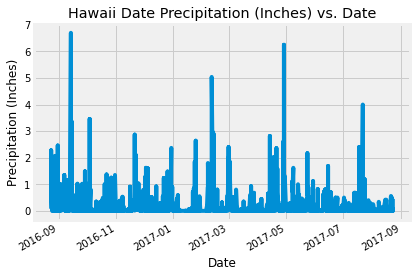

In [145]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Using this date, retrieve the previous 12 months of precipitation data by querying the 12 previous months of data. 
# **Note:** Do not pass in the date as a variable to your query.

dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > (dt.date(2017, 8, 23) - dt.timedelta(days=365))).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rainDF = pd.read_sql_query(
    sql = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > (dt.date(2017, 8, 23) - dt.timedelta(days=365))).statement,
                           con = engine
                          )
rainDF.head()

# Sort the dataframe by date
rainDF_sorted = rainDF.sort_values(by= 'date').dropna()

# checkNull = rainDF.sort_values(by= 'date').dropna()
# checkNull.isnull().values.any()


# convert object to datetime64[ns]
rainDF_sorted["date"] = pd.to_datetime(rainDF_sorted["date"]) 


# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(rainDF_sorted['date'], rainDF_sorted['prcp'])
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Hawaii Date Precipitation (Inches) vs. Date')
plt.tight_layout
plt.gcf().autofmt_xdate()

In [156]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainDF_sorted['prcp'].describe()


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [170]:
engine.execute('SELECT * FROM Station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [157]:
firstRowS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20bf72cdc88>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [164]:
# Design a query to calculate the total number stations in the dataset
engine.execute('SELECT station, COUNT(station) FROM Station').first()

# ORRRR
session.query(func.count(Station.station)).all()

[(9,)]

In [196]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# session.query(func.count(Station.station, Measurement.station)).fetchall()


# engine.execute('SELECT m.station, s.station FROM Measurement m JOIN Station s on m.station = s.station').fetchall()
stationCount = engine.execute('SELECT m.station, COUNT(m.station) FROM Measurement m GROUP BY m.station ORDER BY COUNT(m.station) DESC').fetchall()

stationCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [225]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
activeStation = stationCount[0].station

# ? = will automatically use new updated list
# engine.execute("SELECT * FROM Measurement m WHERE m.station = ?", activeStation).fetchall()


engine.execute('SELECT MAX(m.tobs) FROM Measurement m WHERE m.station LIKE ?', activeStation).fetchall()
engine.execute('SELECT MIN(m.tobs) FROM Measurement m WHERE m.station LIKE ?', activeStation).fetchall()
engine.execute('SELECT AVG(m.tobs) FROM Measurement m WHERE m.station LIKE ?', activeStation).fetchall()



[(71.66378066378067,)]

In [272]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

waiheeTemp_DF = pd.read_sql_query(
    sql = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == activeStation).statement, con = engine)





ValueError: Boolean array expected for the condition, not object

In [250]:
waiheeTemp_DF.tail()

date  tobs
2767  2017-08-14  77.0
2768  2017-08-15  77.0
2769  2017-08-16  76.0
2770  2017-08-17  76.0
2771  2017-08-18  79.0

# Close session

In [ ]:
# Close Session
session.close()

In [ ]:
# Notes

# # convert object to datetime64[ns]
# pd.to_datetime(rainDF_sorted["date"]) 

# waiheeTemp_DF = pd.read_sql_query(
#     sql = session.query(Measurement.date, Measurement.tobs).\
#                     filter(Measurement.station == activeStation & \
#                            (pd.to_datetime("today") - dt.timedelta(days=365)) < (pd.to_datetime(Measurement.date))).\
#                             statement, con = engine)


# pd.to_datetime("today")